# Introduction

# Prerequisite

## Download data

In [ ]:
#!wget --directory-prefix=../data/ https://figshare.com/ndownloader/files/25030028

In [3]:
#!mv ../data/25030028 ../data/pancreas_preprocessed.h5ad

In [ ]:
#!wget --directory-prefix=../data/ https://figshare.com/ndownloader/files/25060877

In [4]:
#!mv ../data/25060877 ../data/pancreas.h5ad

## Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [3]:
adata_preprocessed = sc.read('../data/pancreas_preprocessed.h5ad')
adata_preprocessed.var_names_make_unique
adata_preprocessed

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 

In [4]:
adata = sc.read('../data/pancreas.h5ad')
adata.var_names_make_unique
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
U = adata.layers['unspliced'].toarray()
S = adata.layers['spliced'].toarray()

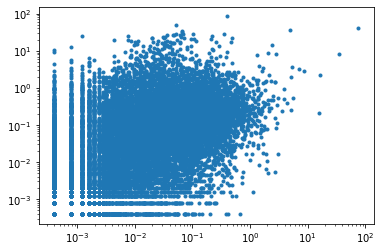

In [7]:
plt.loglog(U.mean(axis=0),S.mean(axis=0),'.');

## Select cells

In [8]:
cell_mask = adata.obs['clusters_coarse'].isin(['Endocrine', 'Fev+'])
subdata = adata[cell_mask]
subdata

View of AnnData object with n_obs × n_vars = 1864 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

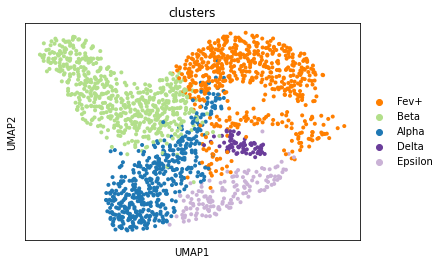

In [9]:
sc.pl.umap(subdata, color='clusters')

## Select genes

In [91]:
marker_genes = ['Pyy', 'Rbp4','Chgb','Fev', 'Cck', 'Neurod1','Vwa5b2','Tox3','Tmem9','Fam183b']

In [92]:
marker_mask = subdata.var_names.isin(marker_genes)

In [109]:
sc.pp.highly_variable_genes(subdata,n_top_genes=2000,flavor="seurat_v3")
gene_mask = marker_mask | (subdata.var['highly_variable']) & (subdata.layers["unspliced"].toarray().mean(axis=0) > 1)
fitted_genes = subdata.var_names[gene_mask]
print(np.sort(fitted_genes))

['Abcc8' 'Actb' 'Ank' 'Auts2' 'Cacna2d1' 'Cck' 'Chgb' 'Cpe' 'Dach1'
 'Fam183b' 'Fev' 'Foxp1' 'Ghr' 'Glud1' 'Gng12' 'Grb10' 'Hspa8' 'Ins2'
 'Itpr1' 'Kcnb2' 'Kcnmb2' 'Kctd8' 'Map2' 'Meg3' 'Meis2' 'Ncam1' 'Neurod1'
 'Nnat' 'Nxph1' 'Pam' 'Pax6' 'Pclo' 'Pcsk2' 'Pde1c' 'Phactr1' 'Pim2'
 'Pip5k1b' 'Plcxd3' 'Ppp1r9a' 'Ppp3ca' 'Prdm16' 'Pyy' 'Rbms3' 'Rbp4'
 'Rbpms' 'Rfx6' 'Rims2' 'Rnf130' 'Runx1t1' 'Setbp1' 'Slc7a14' 'Sphkap'
 'St18' 'Stxbp5l' 'Tmem163' 'Tmem9' 'Tox' 'Tox3' 'Tshz2' 'Vwa5b2' 'Zbtb20']


In [110]:
plot_idx = np.arange(len(fitted_genes))[fitted_genes.isin(marker_genes)]
fitted_genes[plot_idx]

Index(['Fev', 'Tmem9', 'Fam183b', 'Pyy', 'Vwa5b2', 'Rbp4', 'Neurod1', 'Chgb',
       'Tox3', 'Cck'],
      dtype='object', name='index')

## Get X

In [111]:
X = np.zeros((np.sum(cell_mask),np.sum(gene_mask),2))
X[:,:,0] = subdata.layers["unspliced"].toarray()[:,gene_mask]
X[:,:,1] = subdata.layers["spliced"].toarray()[:,gene_mask]
X.shape

(1864, 61, 2)

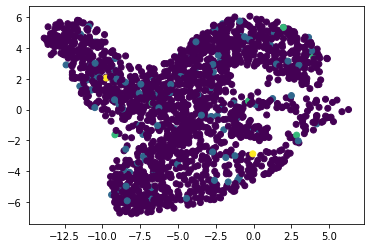

In [112]:
i=20
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=X[:,i,1]);

# Fitting

## Warm start

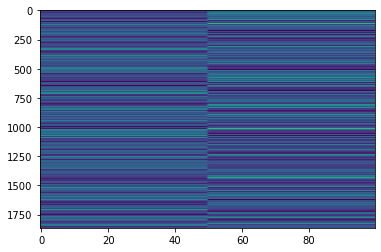

In [113]:
n, p, _ = X.shape
m = 100
Q0 = np.zeros((n,4,m))
Q0[subdata.obs['clusters'].isin(['Fev+']),:,:50]=1
Q0[subdata.obs['clusters'].isin(['Alpha']),0,50:]=1
Q0[subdata.obs['clusters'].isin(['Beta']),1,50:]=1
Q0[subdata.obs['clusters'].isin(['Delta']),2,50:]=1
Q0[subdata.obs['clusters'].isin(['Epsilon']),3,50:]=1
Q0 = Q0/np.sum(Q0,axis=0,keepdims=True)
plt.imshow(Q0[:,0],aspect='auto');

In [114]:
t = Q0[:,0]@np.linspace(0,1,100)

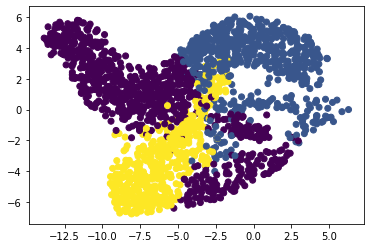

In [115]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=t)

In [116]:
topo = np.array([[0],[1],[2],[3]])
tau = (0,1) # ~24 hours
traj = Trajectory(topo, tau)
Q, elbo = traj.fit(X,Q=Q0,parallel=True,n_threads=20)

run method fit_warm_start


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


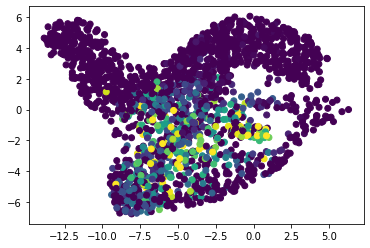

In [117]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,0]@np.linspace(0,1,100))

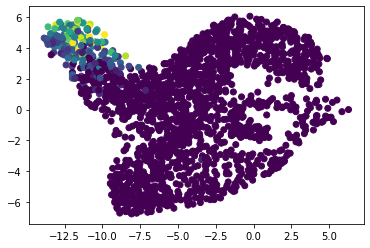

In [118]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,1]@np.linspace(0,1,100))

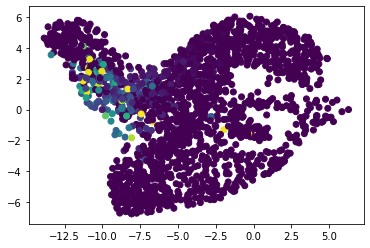

In [119]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,2]@np.linspace(0,1,100))

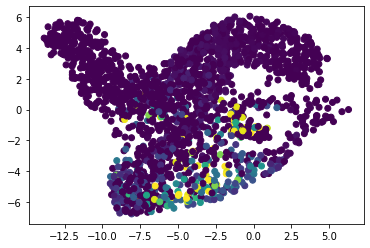

In [120]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,3]@np.linspace(0,1,100))

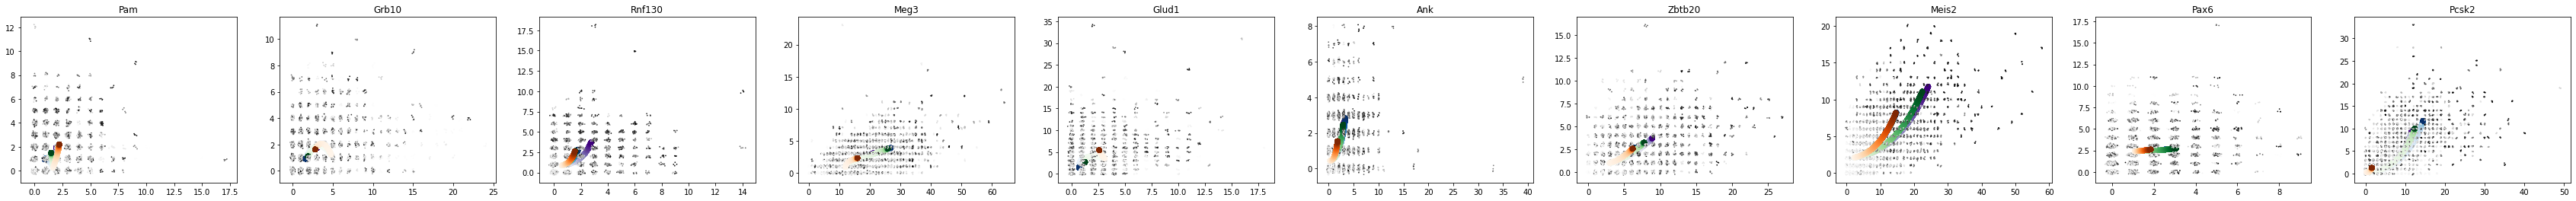

In [30]:
plot_phase(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)

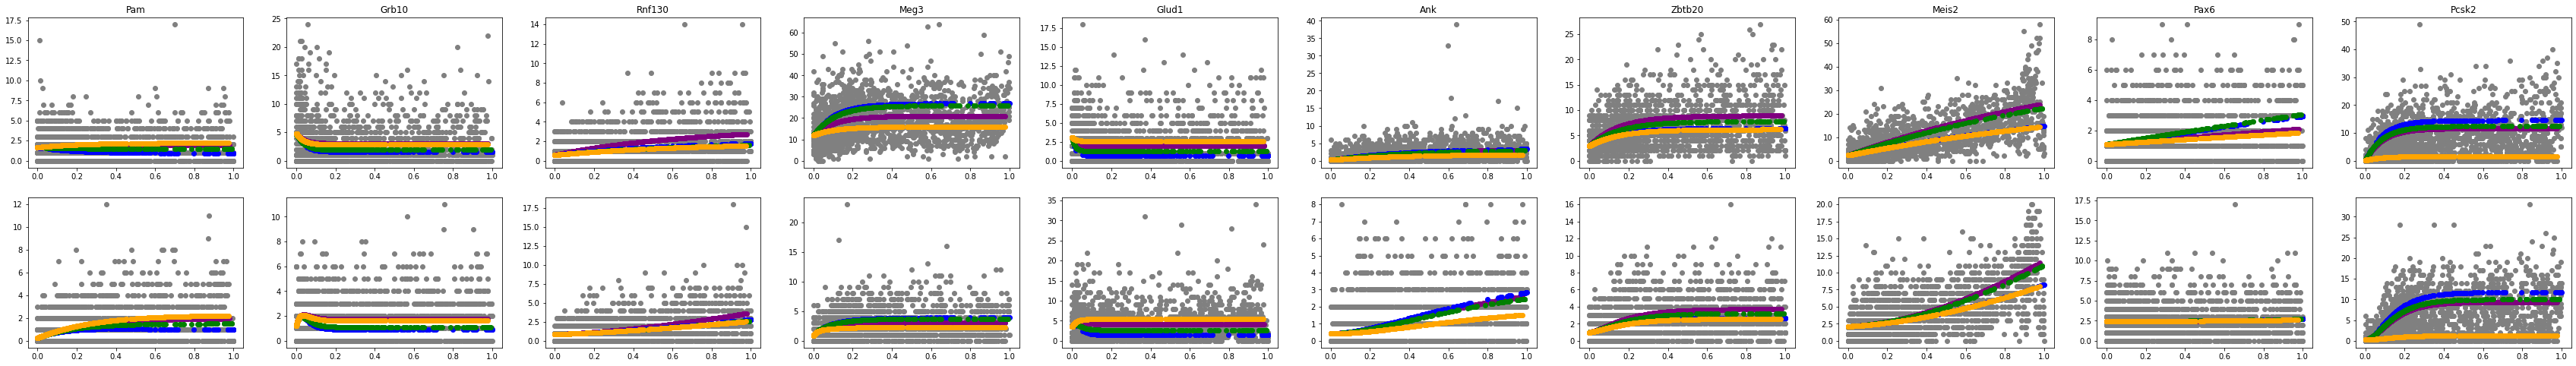

In [29]:
plot_y(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)

## Random initializations

In [121]:
topo = np.array([[0],[1],[2],[3]])
tau = (0,1) # ~24 hours
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X,m=100,n_init=3,parallel=True,n_threads=20)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

trial 2



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

trial 3



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


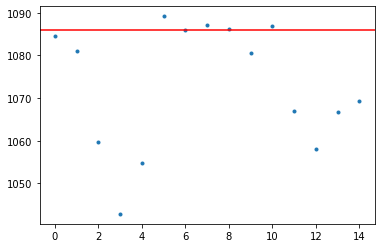

In [122]:
plt.plot(elbos,'.')
plt.axhline(y=elbo,color='r')

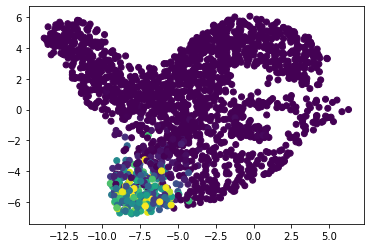

In [80]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,0]@np.linspace(0,1,100))

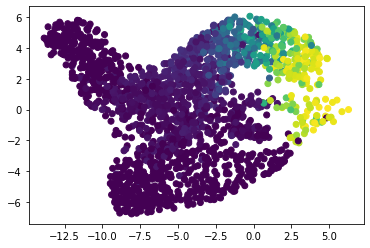

In [81]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,1]@np.linspace(0,1,100))

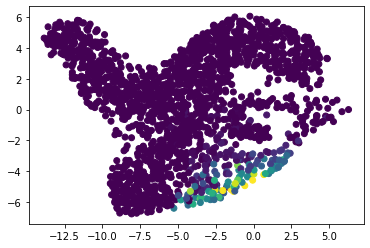

In [82]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,2]@np.linspace(0,1,100))

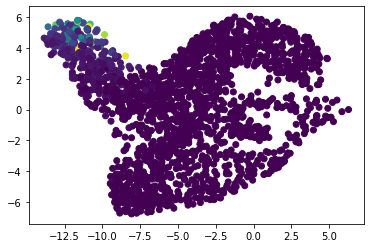

In [83]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=Q[:,3]@np.linspace(0,1,100))

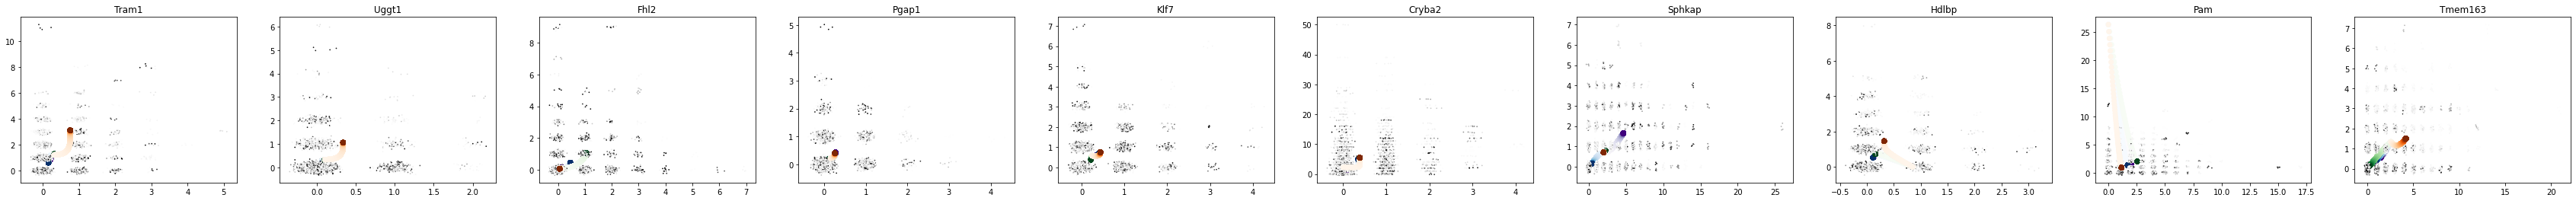

In [86]:
plot_phase(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)

In [ ]:
plot_y(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)